# **Jigsaw Puzzle Solver with JPDVT**
This notebook reorganizes your original Python script into a Jupyter notebook format, preserving the logic and functionality.


Configuration loaded for TEXMET.
Perfect example: 229762_Rachel_Giving_Bilhah_to_Jacob_from_The_Story_of_Ja_primary.jpg
Failed example: 67262_Piece_primary.jpg
                     filename  puzzle_correct  patch_matches  time_s
1486  67262_Piece_primary.jpg               0              2    1.47


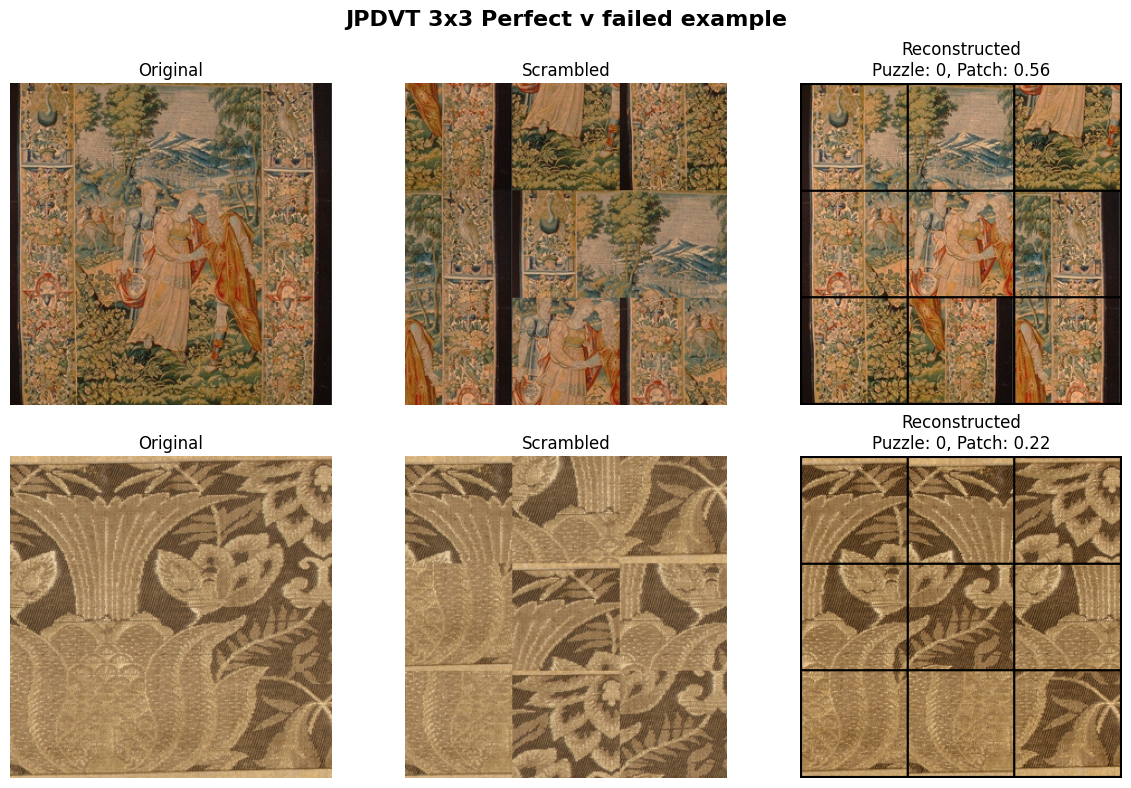

In [3]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

import torchvision
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from models import DiT_models
import argparse
from torch.utils.data import DataLoader
from models import get_2d_sincos_pos_embed
from datasets import MET
import numpy as np
from einops import rearrange
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
from collections import defaultdict
import random

%matplotlib inline

# ======= Configuration for TEXMET =======
MODEL_NAME = "JPDVT"
DATASET_NAME = "texmet"
BASE_DATA_PATH = "/cluster/home/muhamhz/data/TEXMET/images/"
DATA_PATH = ""  # All images are in BASE_DATA_PATH
CROP = False
IMAGE_SIZE = 288
NUM_SAMPLING_STEPS = 250
SEED = 0
CKPT_PATH = "/cluster/home/muhamhz/JPDVT/image_model/results/002-texmet-JPDVT-crop/checkpoints/manual_1752163781-parsit.pt"
GRID_SIZE = 3
CSV_PATH = "/cluster/home/muhamhz/JPDVT/image_model/logs/inference_progress.csv"

FULL_DATA_PATH = BASE_DATA_PATH  # No subfolder for TEXMET test

print("Configuration loaded for TEXMET.")

def imshow_tensor(img_tensor, title="", ax=None):
    """Display a PyTorch tensor as an image"""
    img_tensor = img_tensor * 0.5 + 0.5
    npimg = img_tensor.permute(1, 2, 0).cpu().numpy()
    if ax is None:
        plt.imshow(np.clip(npimg, 0, 1))
        plt.title(title)
        plt.axis("off")
        plt.show()
    else:
        ax.imshow(np.clip(npimg, 0, 1))
        ax.set_title(title)
        ax.axis("off")

def center_crop_arr(pil_image, image_size):
    """Center cropping implementation from ADM"""
    while min(*pil_image.size) >= 2 * image_size:
        pil_image = pil_image.resize(
            tuple(x // 2 for x in pil_image.size), resample=Image.BOX
        )
    scale = image_size / min(*pil_image.size)
    pil_image = pil_image.resize(
        tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC
    )
    arr = np.array(pil_image)
    crop_y = (arr.shape[0] - image_size) // 2
    crop_x = (arr.shape[1] - image_size) // 2
    return Image.fromarray(arr[crop_y: crop_y + image_size, crop_x: crop_x + image_size])

def find_permutation(distance_matrix):
    """Greedy algorithm to find permutation order"""
    sort_list = []
    distance_matrix_copy = distance_matrix.copy()
    for _ in range(distance_matrix.shape[1]):
        order = distance_matrix_copy[:, 0].argmin()
        sort_list.append(order)
        distance_matrix_copy = distance_matrix_copy[:, 1:]
        distance_matrix_copy[order, :] = 2024
    return sort_list

def load_and_process_image(image_path, transform):
    """Load and process a single image"""
    try:
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            return None
        
        pil_image = Image.open(image_path).convert('RGB')
        tensor = transform(pil_image)
        return tensor.unsqueeze(0)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

def create_scrambled_image(x, indices, G, IMAGE_SIZE):
    """Create scrambled image given original image and permutation indices"""
    x_patches = rearrange(
        x, 'b c (p1 h1) (p2 w1) -> b c (p1 p2) h1 w1', 
        p1=G, p2=G, h1=IMAGE_SIZE//G, w1=IMAGE_SIZE//G
    )
    
    x_patches = x_patches[:, :, indices, :, :]
    
    x_scrambled = rearrange(
        x_patches, 'b c (p1 p2) h1 w1 -> b c (p1 h1) (p2 w1)', 
        p1=G, p2=G, h1=IMAGE_SIZE//G, w1=IMAGE_SIZE//G
    )
    
    return x_scrambled, x_patches

def reconstruct_puzzle(scrambled_patches, predicted_order, G):
    """Reconstruct puzzle using predicted ordering"""
    reconstructed_patches = [None] * (G * G)
    for i, pos in enumerate(predicted_order):
        reconstructed_patches[pos] = scrambled_patches[i]
    
    return torch.stack(reconstructed_patches)

def run_inference_on_image(x, model, diffusion, time_emb_noise, G, IMAGE_SIZE):
    """Run inference on a single image and return results"""
    indices = np.random.permutation(G * G)
    
    x_scrambled, x_patches = create_scrambled_image(x, indices, G, IMAGE_SIZE)
    
    scrambled_patches = [x_patches[0, :, i, :, :] for i in range(G * G)]
    
    samples = diffusion.p_sample_loop(
        model.forward, 
        x_scrambled, 
        time_emb_noise.shape, 
        time_emb_noise, 
        clip_denoised=False, 
        model_kwargs=None, 
        progress=False, 
        device=device
    )
    
    for sample in samples:
        sample_patch_dim = IMAGE_SIZE // (16 * G)
        
        sample = rearrange(
            sample, '(p1 h1 p2 w1) d -> (p1 p2) (h1 w1) d', 
            p1=G, p2=G, h1=sample_patch_dim, w1=sample_patch_dim
        )
        
        sample = sample.mean(1)
        
        dist = pairwise_distances(sample.cpu().numpy(), time_emb[0].cpu().numpy(), metric='manhattan')
        order = find_permutation(dist)
        pred = np.asarray(order).argsort()
        
        puzzle_correct = int((pred == indices).all())
        patch_matches = int((pred == indices).sum())
        
        reconstructed_grid = reconstruct_puzzle(scrambled_patches, pred, G)
        
        return {
            'original': x[0],
            'scrambled': x_scrambled[0],
            'reconstructed_grid': reconstructed_grid,
            'true_indices': indices,
            'pred_indices': pred,
            'puzzle_correct': puzzle_correct,
            'patch_matches': patch_matches,
            'scrambled_patches': scrambled_patches
        }

# Load and analyze CSV results
df = pd.read_csv(CSV_PATH)

# Randomly select a perfect and a failed example each run
perfect_cases = df[df['puzzle_correct'] == 1].sample(n=1)
failed_cases = df[df['puzzle_correct'] == 0].sample(n=1)

perfect_filename = perfect_cases.iloc[0]['filename']
failed_filename = failed_cases.iloc[0]['filename']

print("Perfect example:", perfect_filename)
print("Failed example:", failed_filename)

# Setup model and device
torch.manual_seed(SEED)
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DiT_models[MODEL_NAME](input_size=IMAGE_SIZE).to(device)
state_dict = torch.load(CKPT_PATH, weights_only=False)
model_state_dict = state_dict['model']

model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in model_state_dict.items() if k in model_dict}
model.load_state_dict(pretrained_dict, strict=False)
model.train()

diffusion = create_diffusion(str(NUM_SAMPLING_STEPS))

# Setup transforms and embeddings
transform = transforms.Compose([
    transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
])

G = GRID_SIZE
time_emb = torch.tensor(get_2d_sincos_pos_embed(8, G)).unsqueeze(0).float().to(device)
PATCHES_PER_SIDE = IMAGE_SIZE // 16  # 288//16 = 18
time_emb_noise = torch.tensor(get_2d_sincos_pos_embed(8, PATCHES_PER_SIDE)).unsqueeze(0).float().to(device)
time_emb_noise = torch.randn_like(time_emb_noise).repeat(1, 1, 1)

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Perfect case
perfect_path = os.path.join(FULL_DATA_PATH, perfect_filename)
perfect_img = load_and_process_image(perfect_path, transform)

if perfect_img is not None:
    perfect_img = perfect_img.to(device)
    perfect_result = run_inference_on_image(perfect_img, model, diffusion, time_emb_noise, G, IMAGE_SIZE)
    
    # Original
    imshow_tensor(perfect_result['original'], "Original", axes[0, 0])
    
    # Scrambled
    imshow_tensor(perfect_result['scrambled'], "Scrambled", axes[0, 1])
    
    # Reconstructed
    recon_grid = torchvision.utils.make_grid(perfect_result['reconstructed_grid'], nrow=G, normalize=True)
    axes[0, 2].imshow(recon_grid.permute(1, 2, 0).cpu().numpy())
    axes[0, 2].set_title(f"Reconstructed\nPuzzle: {perfect_result['puzzle_correct']}, Patch: {perfect_result['patch_matches']/(G*G):.2f}")
    axes[0, 2].axis("off")

# Failed case
print(failed_cases)
failed_path = os.path.join(FULL_DATA_PATH, failed_filename)
failed_img = load_and_process_image(failed_path, transform)

if failed_img is not None:
    failed_img = failed_img.to(device)
    failed_result = run_inference_on_image(failed_img, model, diffusion, time_emb_noise, G, IMAGE_SIZE)
    
    # Original
    imshow_tensor(failed_result['original'], "Original", axes[1, 0])
    
    # Scrambled
    imshow_tensor(failed_result['scrambled'], "Scrambled", axes[1, 1])
    
    # Reconstructed
    recon_grid = torchvision.utils.make_grid(failed_result['reconstructed_grid'], nrow=G, normalize=True)
    axes[1, 2].imshow(recon_grid.permute(1, 2, 0).cpu().numpy())
    axes[1, 2].set_title(f"Reconstructed\nPuzzle: {failed_result['puzzle_correct']}, Patch: {failed_result['patch_matches']/(G*G):.2f}")
    axes[1, 2].axis("off")

plt.suptitle("JPDVT 3x3 Perfect v failed example", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Found 18644 images in /cluster/home/muhamhz/data/TEXMET/images/
Using device: cuda
Model and diffusion loaded.
Trying image: 216892_Piece_primary.jpg
  Puzzle accuracy: 0 | Patch matches: 4/9
  --> Found failed example: 216892_Piece_primary.jpg
Trying image: 223558_Piece_primary.jpg
  Puzzle accuracy: 0 | Patch matches: 0/9
Trying image: 66576_Piece_primary.jpg
  Puzzle accuracy: 0 | Patch matches: 3/9
Trying image: 217523_Piece_primary.jpg
  Puzzle accuracy: 0 | Patch matches: 1/9
Trying image: 223134_Embroidery_sample_for_a_mans_suit_or_waistcoat_primary.jpg
  Puzzle accuracy: 0 | Patch matches: 7/9
Trying image: 443248_Fragment_of_a_Cover_or_Blanket_with_Interlace_Squa_primary.jpg
  Puzzle accuracy: 0 | Patch matches: 7/9
Trying image: 448943_Brocade_Fragment_primary.jpg
  Puzzle accuracy: 0 | Patch matches: 3/9
Trying image: 216080_Piece_primary.jpg
  Puzzle accuracy: 0 | Patch matches: 5/9
Trying image: 224803_Sample_primary.jpg
  Puzzle accuracy: 0 | Patch matches: 5/9
Trying ima

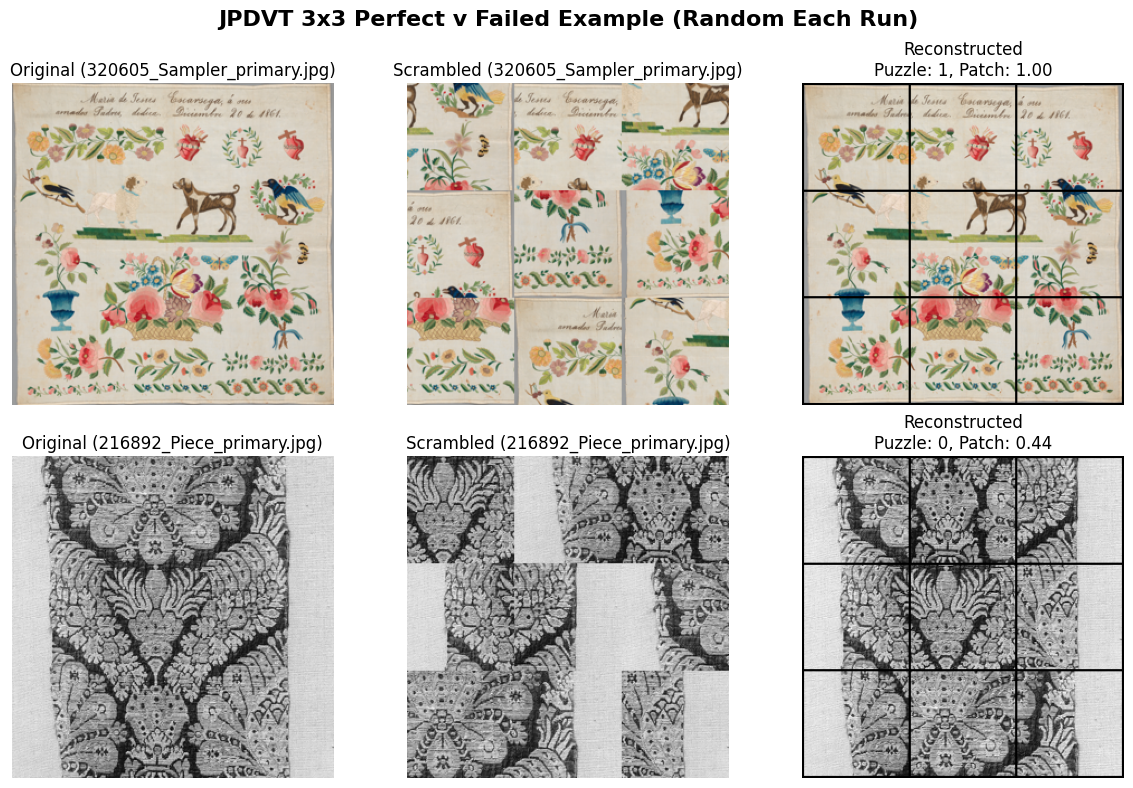

In [15]:
import random

# List all image filenames in your TEXMET directory
all_filenames = [f for f in os.listdir(FULL_DATA_PATH) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"Found {len(all_filenames)} images in {FULL_DATA_PATH}")

# Setup model and device (as before)
torch.manual_seed(SEED)
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = DiT_models[MODEL_NAME](input_size=IMAGE_SIZE).to(device)
state_dict = torch.load(CKPT_PATH, weights_only=False)
model_state_dict = state_dict['model']
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in model_state_dict.items() if k in model_dict}
model.load_state_dict(pretrained_dict, strict=False)
model.train()
diffusion = create_diffusion(str(NUM_SAMPLING_STEPS))
print("Model and diffusion loaded.")

transform = transforms.Compose([
    transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
])

G = GRID_SIZE
time_emb = torch.tensor(get_2d_sincos_pos_embed(8, G)).unsqueeze(0).float().to(device)
PATCHES_PER_SIDE = IMAGE_SIZE // 16  # 288//16 = 18
time_emb_noise = torch.tensor(get_2d_sincos_pos_embed(8, PATCHES_PER_SIDE)).unsqueeze(0).float().to(device)
time_emb_noise = torch.randn_like(time_emb_noise).repeat(1, 1, 1)

# Keep searching until we find one perfect and one failed example
perfect_result = None
failed_result = None
perfect_filename = None
failed_filename = None
attempts = 0

while perfect_result is None or failed_result is None:
    filename = random.choice(all_filenames)
    img_path = os.path.join(FULL_DATA_PATH, filename)
    print(f"Trying image: {filename}")
    img = load_and_process_image(img_path, transform)
    if img is not None:
        img = img.to(device)
        result = run_inference_on_image(img, model, diffusion, time_emb_noise, G, IMAGE_SIZE)
        print(f"  Puzzle accuracy: {result['puzzle_correct']} | Patch matches: {result['patch_matches']}/{G*G}")
        if result['puzzle_correct'] == 1 and perfect_result is None:
            perfect_result = result
            perfect_filename = filename
            print(f"  --> Found perfect example: {filename}")
        elif result['puzzle_correct'] == 0 and failed_result is None:
            failed_result = result
            failed_filename = filename
            print(f"  --> Found failed example: {filename}")
    attempts += 1
    if attempts % 10 == 0:
        print(f"Attempts so far: {attempts}")

print(f"\nSelected perfect: {perfect_filename}, failed: {failed_filename}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Perfect case
imshow_tensor(perfect_result['original'], f"Original ({perfect_filename})", axes[0, 0])
imshow_tensor(perfect_result['scrambled'], f"Scrambled ({perfect_filename})", axes[0, 1])
recon_grid = torchvision.utils.make_grid(perfect_result['reconstructed_grid'], nrow=G, normalize=True)
axes[0, 2].imshow(recon_grid.permute(1, 2, 0).cpu().numpy())
axes[0, 2].set_title(f"Reconstructed\nPuzzle: {perfect_result['puzzle_correct']}, Patch: {perfect_result['patch_matches']/(G*G):.2f}")
axes[0, 2].axis("off")

# Failed case
imshow_tensor(failed_result['original'], f"Original ({failed_filename})", axes[1, 0])
imshow_tensor(failed_result['scrambled'], f"Scrambled ({failed_filename})", axes[1, 1])
recon_grid = torchvision.utils.make_grid(failed_result['reconstructed_grid'], nrow=G, normalize=True)
axes[1, 2].imshow(recon_grid.permute(1, 2, 0).cpu().numpy())
axes[1, 2].set_title(f"Reconstructed\nPuzzle: {failed_result['puzzle_correct']}, Patch: {failed_result['patch_matches']/(G*G):.2f}")
axes[1, 2].axis("off")

plt.suptitle("JPDVT 3x3 Perfect v Failed Example (Random Each Run)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Found 18644 images in /cluster/home/muhamhz/data/TEXMET/images/
Using device: cuda
Model and diffusion loaded.
Trying image: 227008_Chair_panel_primary.jpg
  Puzzle accuracy: 0 | Patch matches: 0/9
  --> Added failed example: 227008_Chair_panel_primary.jpg
Trying image: 223455_Piece_primary.jpg
  Puzzle accuracy: 1 | Patch matches: 9/9
  --> Added perfect example: 223455_Piece_primary.jpg
Trying image: 227183_Piece_primary.jpg
  Puzzle accuracy: 0 | Patch matches: 3/9
  --> Added failed example: 227183_Piece_primary.jpg
Trying image: 698602_Textile_Fragment_primary.jpg
  Puzzle accuracy: 0 | Patch matches: 4/9
  --> Added failed example: 698602_Textile_Fragment_primary.jpg
Trying image: 70585_Buddhist_Altar_Cloth_primary.jpg
  Puzzle accuracy: 0 | Patch matches: 5/9
  --> Added failed example: 70585_Buddhist_Altar_Cloth_primary.jpg
Trying image: 444191_Fragment_of_a_Tunic_primary.jpg
  Puzzle accuracy: 0 | Patch matches: 3/9
  --> Added failed example: 444191_Fragment_of_a_Tunic_primar

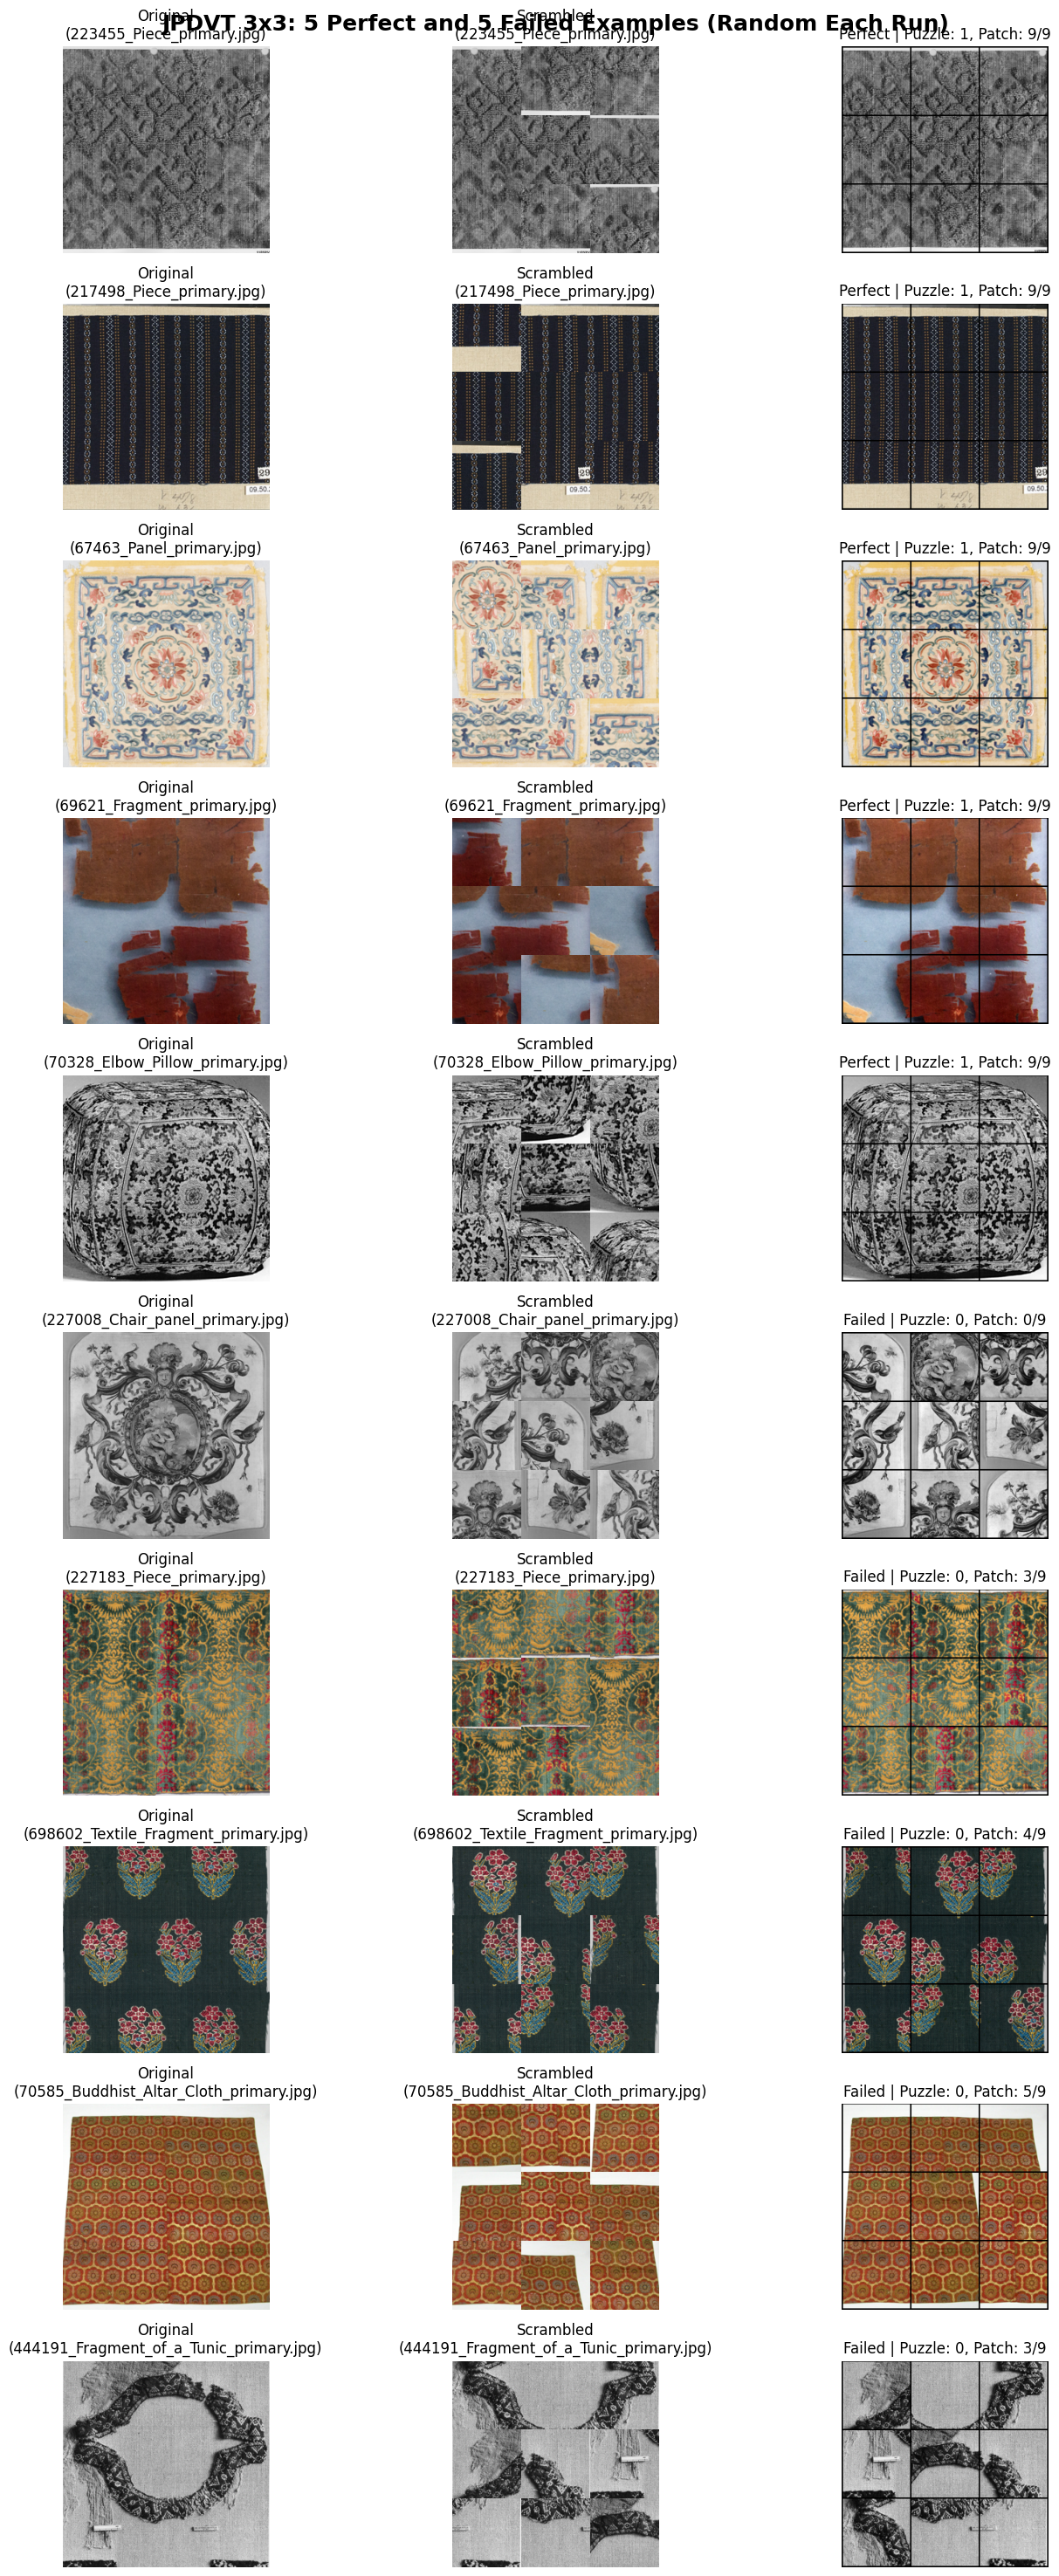

In [16]:
import random

# List all image filenames in your TEXMET directory
all_filenames = [f for f in os.listdir(FULL_DATA_PATH) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"Found {len(all_filenames)} images in {FULL_DATA_PATH}")

# Setup model and device (as before)
torch.manual_seed(SEED)
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = DiT_models[MODEL_NAME](input_size=IMAGE_SIZE).to(device)
state_dict = torch.load(CKPT_PATH, weights_only=False)
model_state_dict = state_dict['model']
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in model_state_dict.items() if k in model_dict}
model.load_state_dict(pretrained_dict, strict=False)
model.train()
diffusion = create_diffusion(str(NUM_SAMPLING_STEPS))
print("Model and diffusion loaded.")

transform = transforms.Compose([
    transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
])

G = GRID_SIZE
time_emb = torch.tensor(get_2d_sincos_pos_embed(8, G)).unsqueeze(0).float().to(device)
PATCHES_PER_SIDE = IMAGE_SIZE // 16  # 288//16 = 18
time_emb_noise = torch.tensor(get_2d_sincos_pos_embed(8, PATCHES_PER_SIDE)).unsqueeze(0).float().to(device)
time_emb_noise = torch.randn_like(time_emb_noise).repeat(1, 1, 1)

# Collect 5 perfect and 5 failed examples
perfect_results = []
failed_results = []
attempts = 0

while len(perfect_results) < 5 or len(failed_results) < 5:
    filename = random.choice(all_filenames)
    img_path = os.path.join(FULL_DATA_PATH, filename)
    print(f"Trying image: {filename}")
    img = load_and_process_image(img_path, transform)
    if img is not None:
        img = img.to(device)
        result = run_inference_on_image(img, model, diffusion, time_emb_noise, G, IMAGE_SIZE)
        print(f"  Puzzle accuracy: {result['puzzle_correct']} | Patch matches: {result['patch_matches']}/{G*G}")
        if result['puzzle_correct'] == 1 and len(perfect_results) < 5:
            perfect_results.append((filename, result))
            print(f"  --> Added perfect example: {filename}")
        elif result['puzzle_correct'] == 0 and len(failed_results) < 5:
            failed_results.append((filename, result))
            print(f"  --> Added failed example: {filename}")
    attempts += 1
    if attempts % 10 == 0:
        print(f"Attempts so far: {attempts} | Perfect: {len(perfect_results)} | Failed: {len(failed_results)}")

print(f"\nSelected {len(perfect_results)} perfect and {len(failed_results)} failed examples.")

# Visualization: 10 rows (5 perfect, 5 failed), 3 columns (original, scrambled, reconstructed)
fig, axes = plt.subplots(10, 3, figsize=(15, 30))

for i, (filename, result) in enumerate(perfect_results + failed_results):
    row_type = "Perfect" if i < 5 else "Failed"
    # Original
    imshow_tensor(result['original'], f"Original\n({filename})", axes[i, 0])
    # Scrambled
    imshow_tensor(result['scrambled'], f"Scrambled\n({filename})", axes[i, 1])
    # Reconstructed
    recon_grid = torchvision.utils.make_grid(result['reconstructed_grid'], nrow=G, normalize=True)
    axes[i, 2].imshow(recon_grid.permute(1, 2, 0).cpu().numpy())
    axes[i, 2].set_title(
        f"{row_type} | Puzzle: {result['puzzle_correct']}, Patch: {result['patch_matches']}/{G*G}"
    )
    axes[i, 2].axis("off")

plt.suptitle("JPDVT 3x3: 5 Perfect and 5 Failed Examples (Random Each Run)", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

Loaded 1865 rows from /cluster/home/muhamhz/JPDVT/image_model/logs/inference_progress.csv
Total samples: 1865
Perfect puzzles (all correct): 79 (4.24%)
Failed puzzles (not all correct): 1786 (95.76%)
Mean patch accuracy: 33.41%
Mean solve time: 1.49 seconds


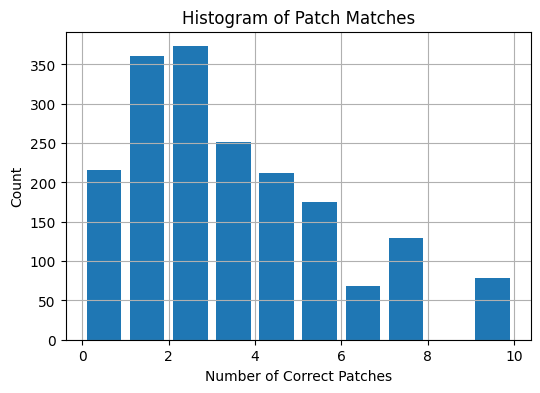

In [17]:
import pandas as pd

# Read the CSV file
df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df)} rows from {CSV_PATH}")

# Basic stats
total = len(df)
num_perfect = (df['puzzle_correct'] == 1).sum()
num_failed = (df['puzzle_correct'] == 0).sum()
mean_patch_acc = df['patch_matches'].mean() / (GRID_SIZE * GRID_SIZE)
mean_time = df['time_s'].mean()

print(f"Total samples: {total}")
print(f"Perfect puzzles (all correct): {num_perfect} ({num_perfect/total:.2%})")
print(f"Failed puzzles (not all correct): {num_failed} ({num_failed/total:.2%})")
print(f"Mean patch accuracy: {mean_patch_acc:.2%}")
print(f"Mean solve time: {mean_time:.2f} seconds")

# Optional: histogram of patch matches
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
df['patch_matches'].hist(bins=range(GRID_SIZE*GRID_SIZE+2), rwidth=0.8)
plt.xlabel("Number of Correct Patches")
plt.ylabel("Count")
plt.title("Histogram of Patch Matches")
plt.show()

In [5]:
# --- Place this in a new cell near your model loading code ---

import torch

# Load the checkpoint
state_dict = torch.load(CKPT_PATH, weights_only=False)

# Print all keys in the checkpoint
print("Checkpoint keys:", state_dict.keys())

# Try to print possible training metadata if present
if 'epoch' in state_dict:
    print("Trained epochs:", state_dict['epoch'])
if 'step' in state_dict:
    print("Training step:", state_dict['step'])
if 'args' in state_dict:
    print("Training args:", state_dict['args'])
if 'config' in state_dict:
    print("Training config:", state_dict['config'])

Checkpoint keys: dict_keys(['model'])
